Инициализация.
---

In [1]:
import sys
cadEditorDir = "d:/DEV/CadEditor/CadEditor/"
sys.path.append(cadEditorDir)

import clr
clr.AddReference("CadEditor")
clr.AddReference("PluginVideoNes")

from PluginVideoNes import Video
from CadEditor import UtilsGDI
from System.Drawing import Bitmap
from System import Array, Byte
import array

In [2]:
romName = cadEditorDir + "/Yo! Noid (U) [!].nes"
with open(romName, "rb") as f:
    d = f.read()

Отображение видеобанка
---

In [3]:
#Создаём экземляр плагина для отрисовки NES-графики
video = Video()

In [10]:
def toDotNetArray(data):
    return  Array[Byte](array.array('B', data))

CHR_ADDR = 0x23010 #адрес банка видеопамяти для фона первого уровня
CHR_BANK_SIZE = 0x1000
chrData = d[CHR_ADDR:CHR_ADDR + CHR_BANK_SIZE]
chrData = toDotNetArray(chrData)

PAL_ADDR = 0x1AAEE #адрес палитры
PAL_SIZE = 16
palData = d[PAL_ADDR:PAL_ADDR + PAL_SIZE]
palData = toDotNetArray(palData)

In [12]:
chrBitmap = video.makeImageRectangle(chrData, palData, 0, False)

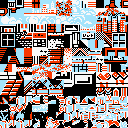

In [13]:
from IPython.display import display, Image
picPath = "D:/CadEditorPythonExamples/"
#сохраняем картинку в файл:
chrBitmap.Save(picPath+"chr0.png")

#отображаем её:
Image(filename=picPath+"chr0.png")

Отображение игровых блоков
---

Блоки в игре - это структуры размером 4x4 тайла, описываемые набором из 16 тайлов слева-направо сверху вниз. Для каждого блока также хранится 1 байт палитры (по 2 бита на подблок размером 2x2 тайла). Таким образом описания блока занимает 17 байт.

Например, описание одного из блоков:
<pre>
4440 - 16 тайлов видеопамяти
43B6 - байт палитры блока, по два бита на каждый квадрат 2x2.
(справа-налево, сверху-вниз)
</pre>
Рассмотрим построение изображения этого и соседних блоков:

In [27]:
def renderBlock(TILE_INDEX_ADDR, PAL_BYTE_ADDR):
    tileIndexes = d[TILE_INDEX_ADDR:TILE_INDEX_ADDR+16]
    palByte = d[PAL_BYTE_ADDR]
    #разложение на биты палитр для каждого из подблоков 2x2
    palBits = [
        (palByte>>0)&3, (palByte>>0)&3, (palByte>>2)&3, (palByte>>2)&3,
        (palByte>>0)&3, (palByte>>0)&3, (palByte>>2)&3, (palByte>>2)&3,
        (palByte>>4)&3, (palByte>>4)&3, (palByte>>6)&3, (palByte>>6)&3,
        (palByte>>4)&3, (palByte>>4)&3, (palByte>>6)&3, (palByte>>6)&3,
    ]

    #строим 16 тайлов блока
    tiles = [video.makeImage(tileIndex, chrData, palData, palBit, False) for (tileIndex, palBit) in zip(tileIndexes, palBits)]
    tiles =  Array[Bitmap](tiles)
    #склеиваем их вместе
    tileImage = UtilsGDI.GlueImages(tiles, 4,4)
    return tileImage

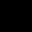

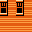

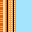

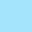

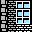

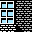

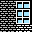

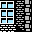

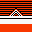

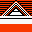

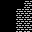

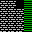

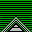

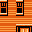

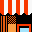

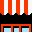

In [28]:
blocks = []
#-------------------------------------------------------
BLOCKS_COUNT = 138
for x in range(BLOCKS_COUNT):
    TILE_INDEX_ADDR = 0x4440 + x*16
    PAL_BYTE_ADDR = 0x43B6 + x
    blockImage = renderBlock(TILE_INDEX_ADDR, PAL_BYTE_ADDR)
    blocks.append(blockImage)

#отображаем первые 16 блоков
for x in range(16):
    blockImage = blocks[x]
    #сохраняем картинку в файл:
    blockImage.Save(picPath+"block%d.png"%x)
    #отображаем её:
    display(Image(filename=picPath+"block%d.png"%x))

Кроме этого, каждый из 128 тайлов видеопамяти имеет характеристику проходимости, которая описывается диапазонами байт (для первого уровня в ROM: 0x4026 - 3 байта ответственных за физику, задают диапазоны блоков по типам - "фон", "стена", "платформа", "шипы".

Построение экранов
---

Экраны описываются индексами блоков в порядке сверху-вниз слева-направо. Высота экрана - 7 блоков.

In [30]:
screenData = []
SCREEN_BEGIN_ADDR = 0x4036
SCREEN_WIDTH = 128
SCREEN_HEIGHT = 7
#считываем столбы
for x in range(SCREEN_WIDTH):
    colAddr = SCREEN_BEGIN_ADDR+x*SCREEN_HEIGHT
    column = d[colAddr:colAddr+SCREEN_HEIGHT]
    screenData.append(column)
    
#транспонируем строки и столбцы, чтобы экран описывался построчно, а не постолбцово
screenData = [list(x) for x in zip(*screenData)]
#разворачиваем матрицу в плоский список
screenData = [item for sublist in screenData for item in sublist]

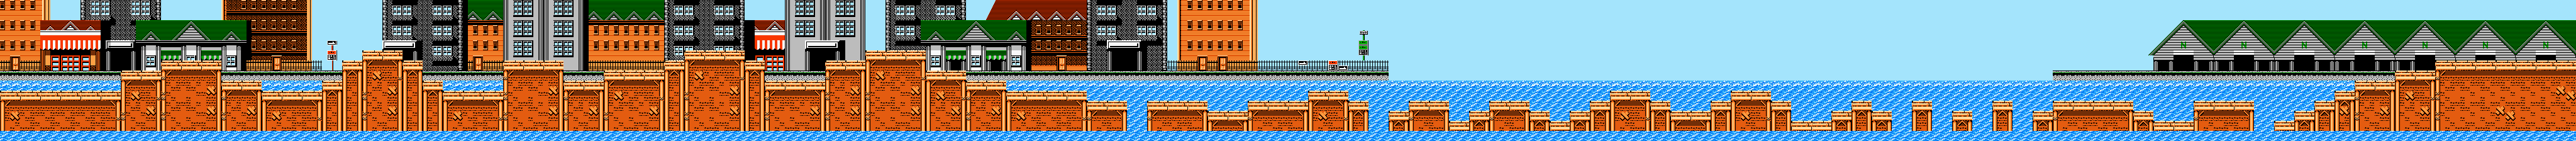

In [31]:
screenBlocks = [blocks[x] for x in screenData]
screenImage = UtilsGDI.GlueImages(Array[Bitmap](screenBlocks), 128,7)
screenImage.Save(picPath+"screen0.png")
Image(filename=picPath+"screen0.png")